In [1]:
library("ggplot2")
library("dplyr")
library("tidyr")
library(MMWRweek)
library(quantreg)
library("lubridate")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SparseM


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [67]:
# Read data from 2020-2021
us_death = read.csv(file="../data//Provisional_COVID-19_Death_Counts_by_Week_Ending_Date_and_State.csv")
us_death$Week.Ending.Date = mdy(us_death$Week.Ending.Date)
us_death = us_death[us_death$State == "United States", ]
us_death = us_death[year(us_death$Week.Ending.Date) < 2022, ]
us_death = us_death[!is.na(us_death$Total.Deaths) & !is.na(us_death$Week.Ending.Date), ]
head(us_death)

,Data.as.of,Start.Date,End.Date,Group,Year,Month,MMWR.Week,Week.Ending.Date,State,COVID.19.Deaths,Total.Deaths,Percent.of.Expected.Deaths,Pneumonia.Deaths,Pneumonia.and.COVID.19.Deaths,Influenza.Deaths,Pneumonia..Influenza..or.COVID.19.Deaths,Footnote
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<date>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,01/27/2022,12/29/2019,01/04/2020,By Week,2019/2020,NA,1,2020-01-04,United States,0,60173,98,4111,0,434,4545,
2,01/27/2022,01/05/2020,01/11/2020,By Week,2020,NA,2,2020-01-11,United States,1,60732,97,4153,1,475,4628,
3,01/27/2022,01/12/2020,01/18/2020,By Week,2020,NA,3,2020-01-18,United States,2,59359,98,4066,2,468,4534,
4,01/27/2022,01/19/2020,01/25/2020,By Week,2020,NA,4,2020-01-25,United States,2,59158,99,3915,0,500,4417,
5,01/27/2022,01/26/2020,02/01/2020,By Week,2020,NA,5,2020-02-01,United States,0,58826,99,3818,0,481,4299,
6,01/27/2022,02/02/2020,02/08/2020,By Week,2020,NA,6,2020-02-08,United States,3,59478,100,3823,1,521,4346,


In [68]:
# Read data from 2014-2019
us_death_old = read.csv("../data/Weekly_Counts_of_Deaths_by_State_and_Select_Causes__2014-2019.csv")
us_death_old$Week.Ending.Date = mdy(us_death_old$Week.Ending.Date)
us_death_old = us_death_old[us_death_old$Jurisdiction.of.Occurrence == "United States", ]
us_death_old = us_death_old[!is.na(us_death_old$All..Cause) & !is.na(us_death_old$Week.Ending.Date), ]
head(us_death_old)

,Jurisdiction.of.Occurrence,MMWR.Year,MMWR.Week,Week.Ending.Date,All..Cause,Natural.Cause,Septicemia..A40.A41.,Malignant.neoplasms..C00.C97.,Diabetes.mellitus..E10.E14.,Alzheimer.disease..G30.,⋯,flag_neopl,flag_diab,flag_alz,flag_inflpn,flag_clrd,flag_otherresp,flag_nephr,flag_otherunk,flag_hd,flag_stroke
,<chr>,<int>,<int>,<date>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,United States,2014,1,2014-01-04,54065,50189,882,11244,1654,1780,⋯,,,,,,,,,,
2,United States,2014,2,2014-01-11,56353,52450,905,11504,1735,1917,⋯,,,,,,,,,,
3,United States,2014,3,2014-01-18,54769,51043,919,11496,1660,1914,⋯,,,,,,,,,,
4,United States,2014,4,2014-01-25,54223,50560,845,11629,1602,1862,⋯,,,,,,,,,,
5,United States,2014,5,2014-02-01,54074,50402,890,11584,1586,1867,⋯,,,,,,,,,,
6,United States,2014,6,2014-02-08,53484,49790,849,11355,1643,1873,⋯,,,,,,,,,,


In [69]:
# Combine both data sets
us_death_old$Total.Deaths = us_death_old$All..Cause
us_death_old$data_set = "2014-2019"
us_death$data_set = "2020-2021"
us_death_all = rbind(us_death_old[,c("Week.Ending.Date", "Total.Deaths", "data_set", "MMWR.Week")], 
                                  us_death[,c("Week.Ending.Date", "Total.Deaths", "data_set", "MMWR.Week")])
head(us_death_all)

,Week.Ending.Date,Total.Deaths,data_set,MMWR.Week
,<date>,<int>,<chr>,<int>
1,2014-01-04,54065,2014-2019,1
2,2014-01-11,56353,2014-2019,2
3,2014-01-18,54769,2014-2019,3
4,2014-01-25,54223,2014-2019,4
5,2014-02-01,54074,2014-2019,5
6,2014-02-08,53484,2014-2019,6


Smoothing formula not specified. Using: y ~ x



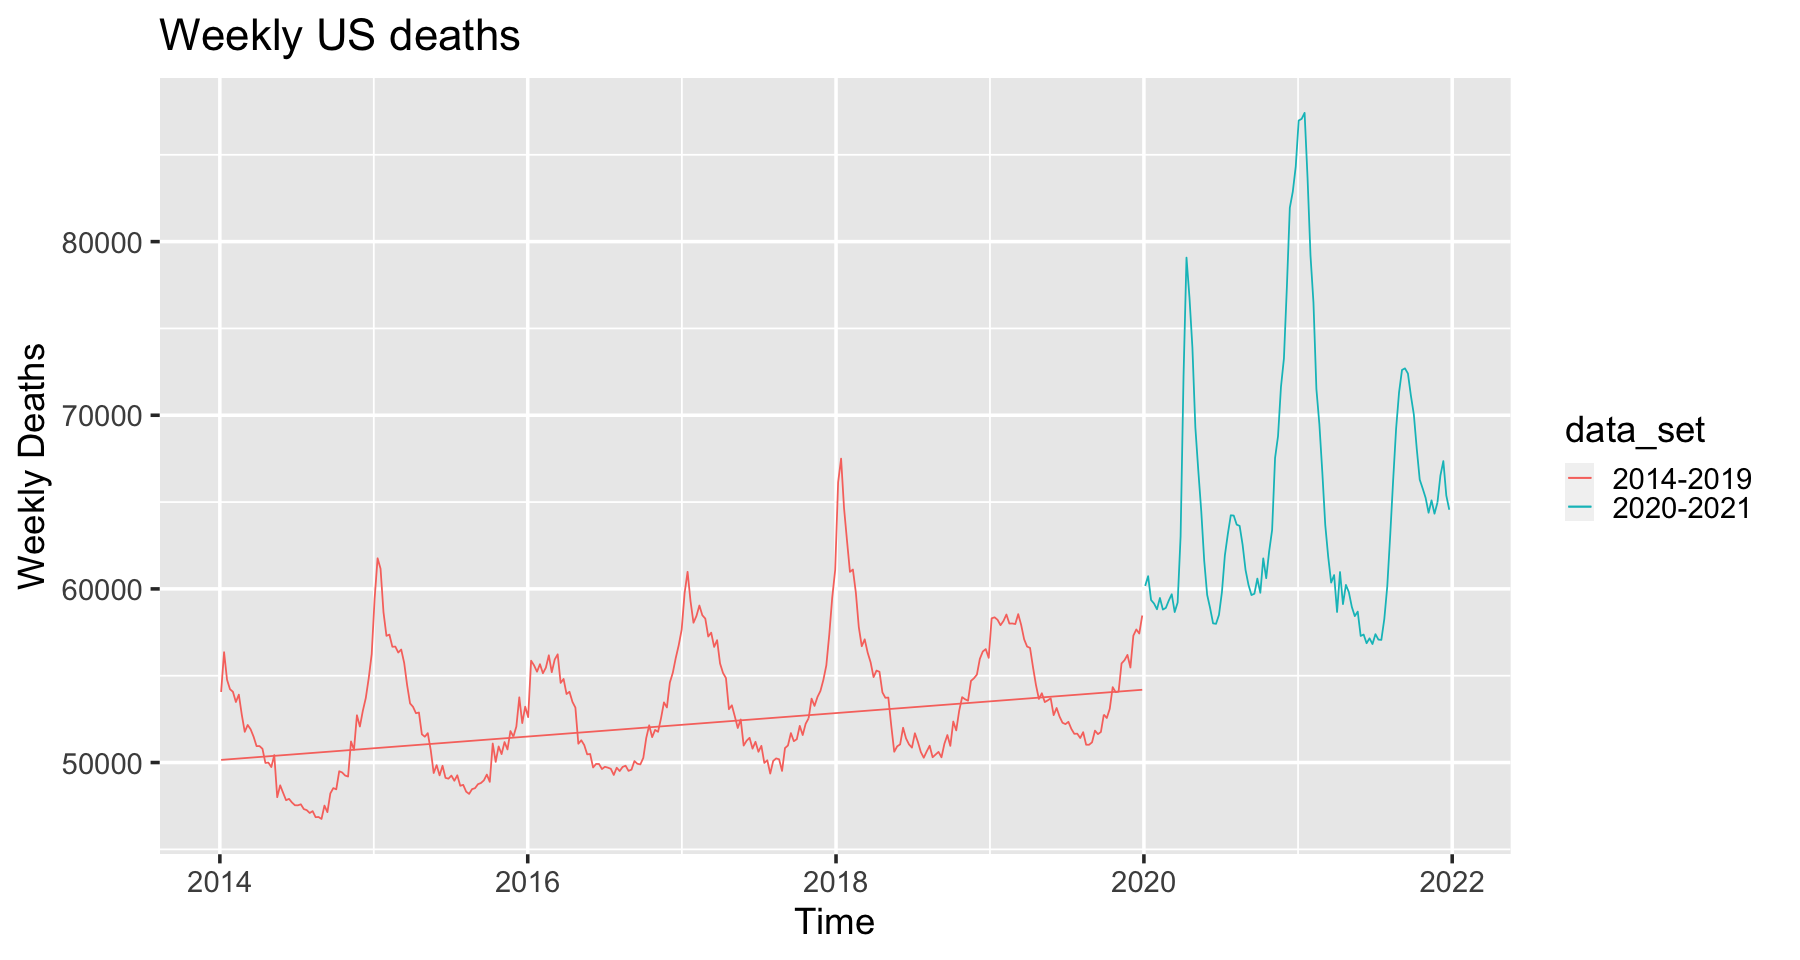

In [70]:
# Plot with quantile trend from 2014-2019
options(repr.plot.width=15, repr.plot.height=8)
b = ggplot(us_death_all, aes(x=Week.Ending.Date, y=Total.Deaths, color=data_set))
b + geom_line() + 
theme_gray(base_size = 22) + 
labs(x = "Time", y = "Weekly Deaths", title="Weekly US deaths") +
geom_quantile(aes(), data=us_death_all[us_death_all$data_set=="2014-2019",], quantiles=c(0.5))

In [71]:
# Fit a trend of 50th quantile from 2014-2019
us_death_all$days = us_death_all$Week.Ending.Date - us_death_all$Week.Ending.Date[1]
rq.fit = rq(Total.Deaths ~ days, data=us_death_all[us_death_all$data_set=="2014-2019",])
us_death_all$detrended = as.numeric(us_death_all$Total.Deaths - us_death_all$days * rq.fit$coef[2])
summary(rq.fit)


Call: rq(formula = Total.Deaths ~ days, data = us_death_all[us_death_all$data_set == 
    "2014-2019", ])

tau: [1] 0.5

Coefficients:
            coefficients lower bd    upper bd   
(Intercept) 50152.60618  49198.72702 50818.35385
days            1.84887      1.31292     2.56260

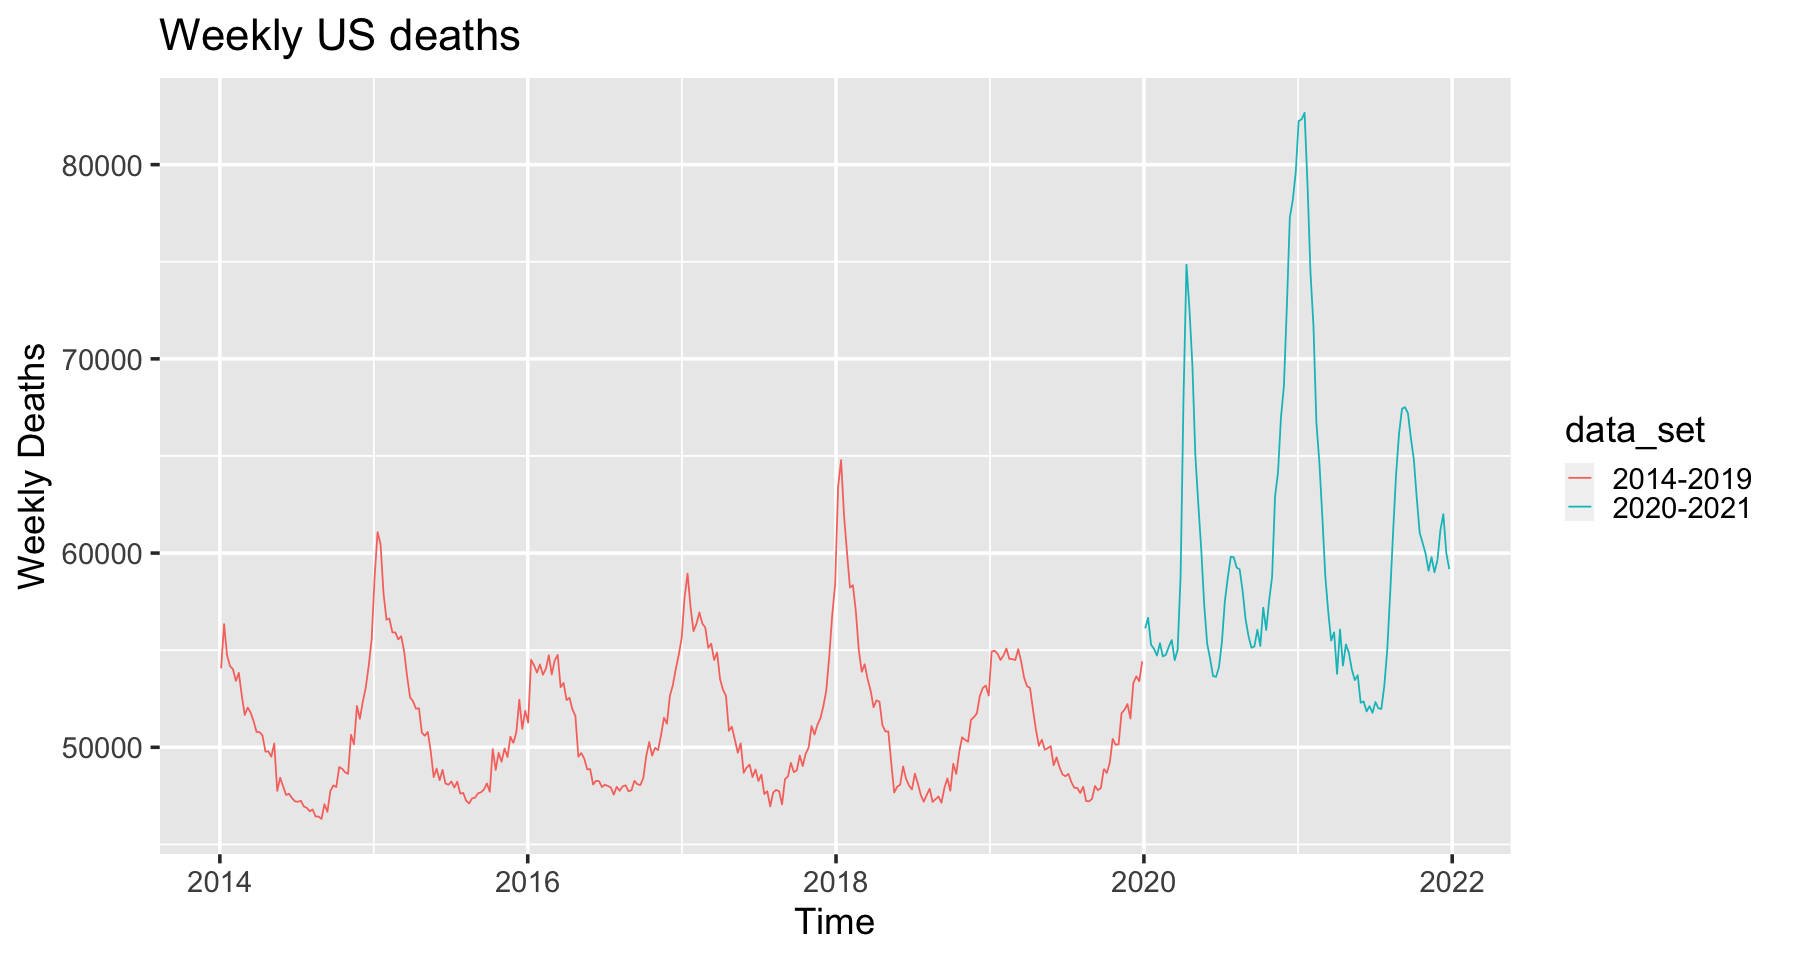

In [72]:
# plot detrended deaths
options(repr.plot.width=15, repr.plot.height=8)
b = ggplot(us_death_all, aes(x=Week.Ending.Date, y=detrended, color=data_set))
b + geom_line() + 
theme_gray(base_size = 22) + 
labs(x = "Time", y = "Weekly Deaths", title="Weekly US deaths")

In [73]:
# Subtract weekly median from 2014-2019
median = us_death_all[us_death_all$data_set=="2014-2019",] %>% group_by(MMWR.Week) %>% summarise(med = median(detrended))
merged = merge(us_death_all, median, by="MMWR.Week")
head(merged)
merged$centered = merged$detrended - merged$med

,MMWR.Week,Week.Ending.Date,Total.Deaths,data_set,days,detrended,med
,<int>,<date>,<int>,<chr>,<drtn>,<dbl>,<dbl>
1,1,2014-01-04,54065,2014-2019,0 days,54065.00,56329.6
2,1,2020-01-04,60173,2020-2021,2191 days,56122.13,56329.6
3,1,2019-01-05,58305,2014-2019,1827 days,54927.12,56329.6
4,1,2021-01-09,87069,2020-2021,2562 days,82332.20,56329.6
5,1,2018-01-06,66142,2014-2019,1463 days,63437.10,56329.6
6,1,2015-01-10,61763,2014-2019,371 days,61077.07,56329.6


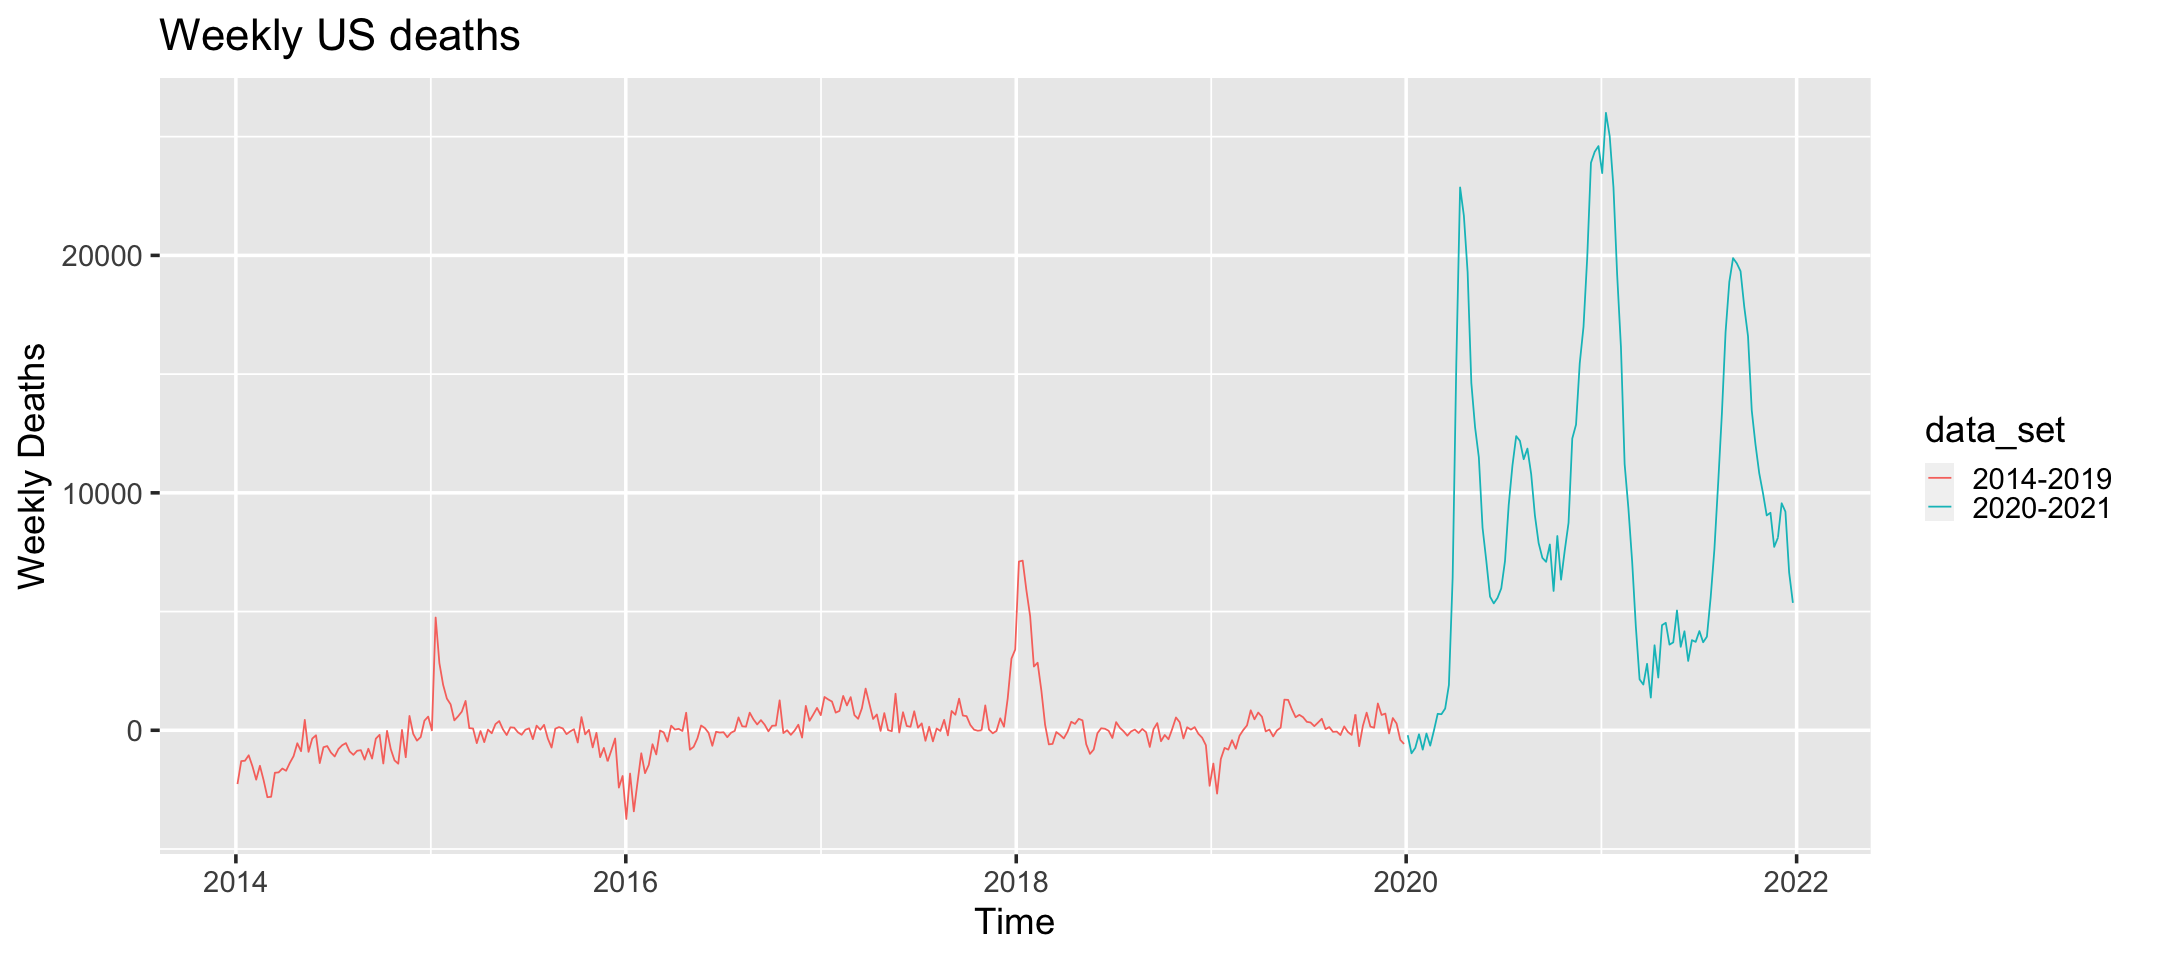

In [74]:
# plot centered deaths
options(repr.plot.width=18, repr.plot.height=8)
b = ggplot(merged, aes(x=Week.Ending.Date, y=centered, color=data_set))
b + geom_line() + 
theme_gray(base_size = 22) + 
labs(x = "Time", y = "Weekly Deaths", title="Weekly US deaths")

In [13]:
# Normalize deaths
merged$normalized = (merged$centered - min(merged$centered)) / (max(merged$centered) - min(merged$centered))

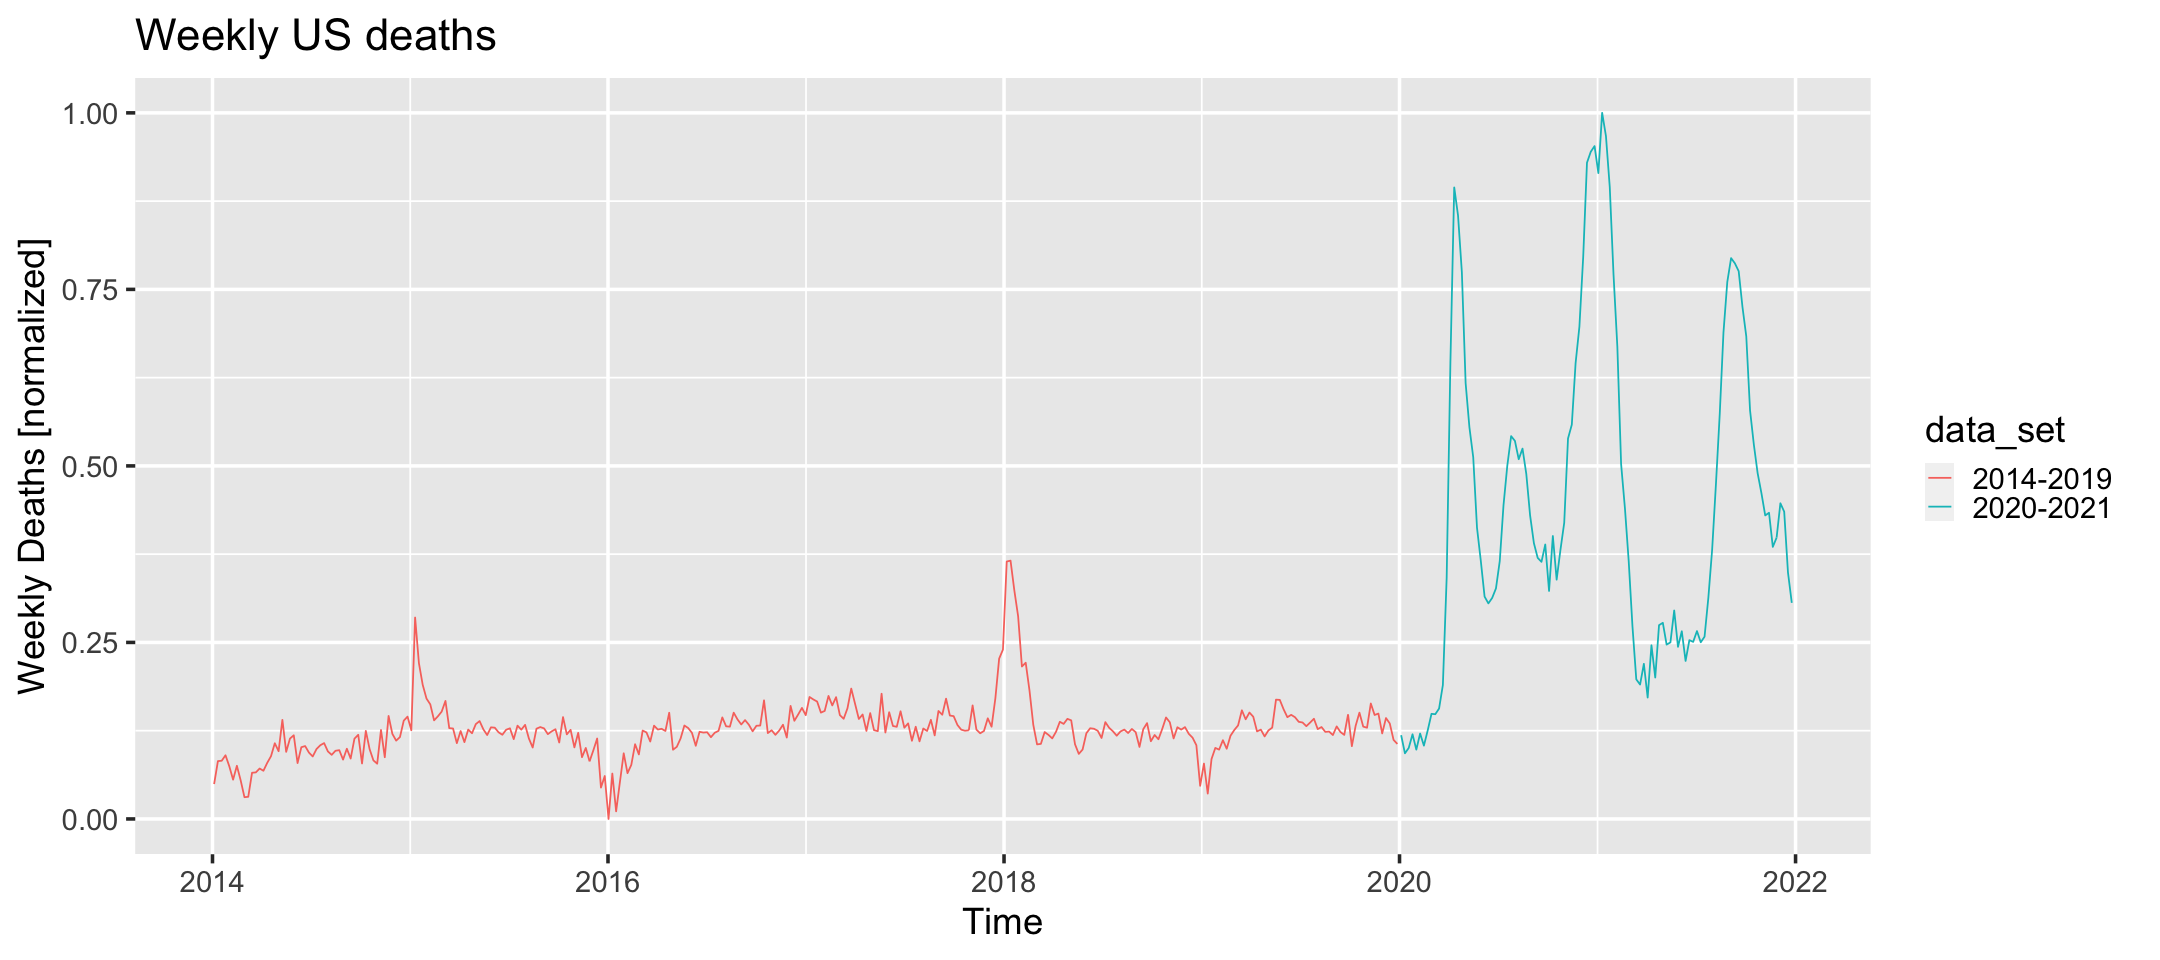

In [14]:
# plot centered deaths
b = ggplot(merged, aes(x=Week.Ending.Date, y=normalized, color=data_set))
b + geom_line() + 
theme_gray(base_size = 22) + 
labs(x = "Time", y = "Weekly Deaths [normalized]", title="Weekly US deaths")

In [86]:
######################
# Statewide analysis #
######################
# Here we show the following
# 1. Raw statewide death counts
# 2. Normalized statewide death counts
# 3. Relative contribution from each state
# California	0.12407822
# `New York City`	0.11347172
# Florida	0.06615664
# Texas	0.06427249
us_death = read.csv(file="../data//Provisional_COVID-19_Death_Counts_by_Week_Ending_Date_and_State.csv")
us_death$Week.Ending.Date = mdy(us_death$Week.Ending.Date)
us_death = us_death[year(us_death$Week.Ending.Date) < 2022, ]
us_death = us_death[!is.na(us_death$Total.Deaths) & !is.na(us_death$Week.Ending.Date), ]

# Read data from 2014-2019
us_death_old = read.csv("../data/Weekly_Counts_of_Deaths_by_State_and_Select_Causes__2014-2019.csv")
us_death_old$Week.Ending.Date = mdy(us_death_old$Week.Ending.Date)
us_death_old = us_death_old[!is.na(us_death_old$All..Cause) & !is.na(us_death_old$Week.Ending.Date), ]
us_death_old$Total.Deaths = us_death_old$All..Cause
us_death_old$data_set = "2014-2019"
us_death$data_set = "2020-2021"
us_death_old$State = us_death_old$Jurisdiction.of.Occurrence
us_death_all = rbind(us_death_old[,c("Week.Ending.Date", "Total.Deaths", "data_set", "MMWR.Week", "State")], 
                                  us_death[,c("Week.Ending.Date", "Total.Deaths", "data_set", "MMWR.Week", "State")])

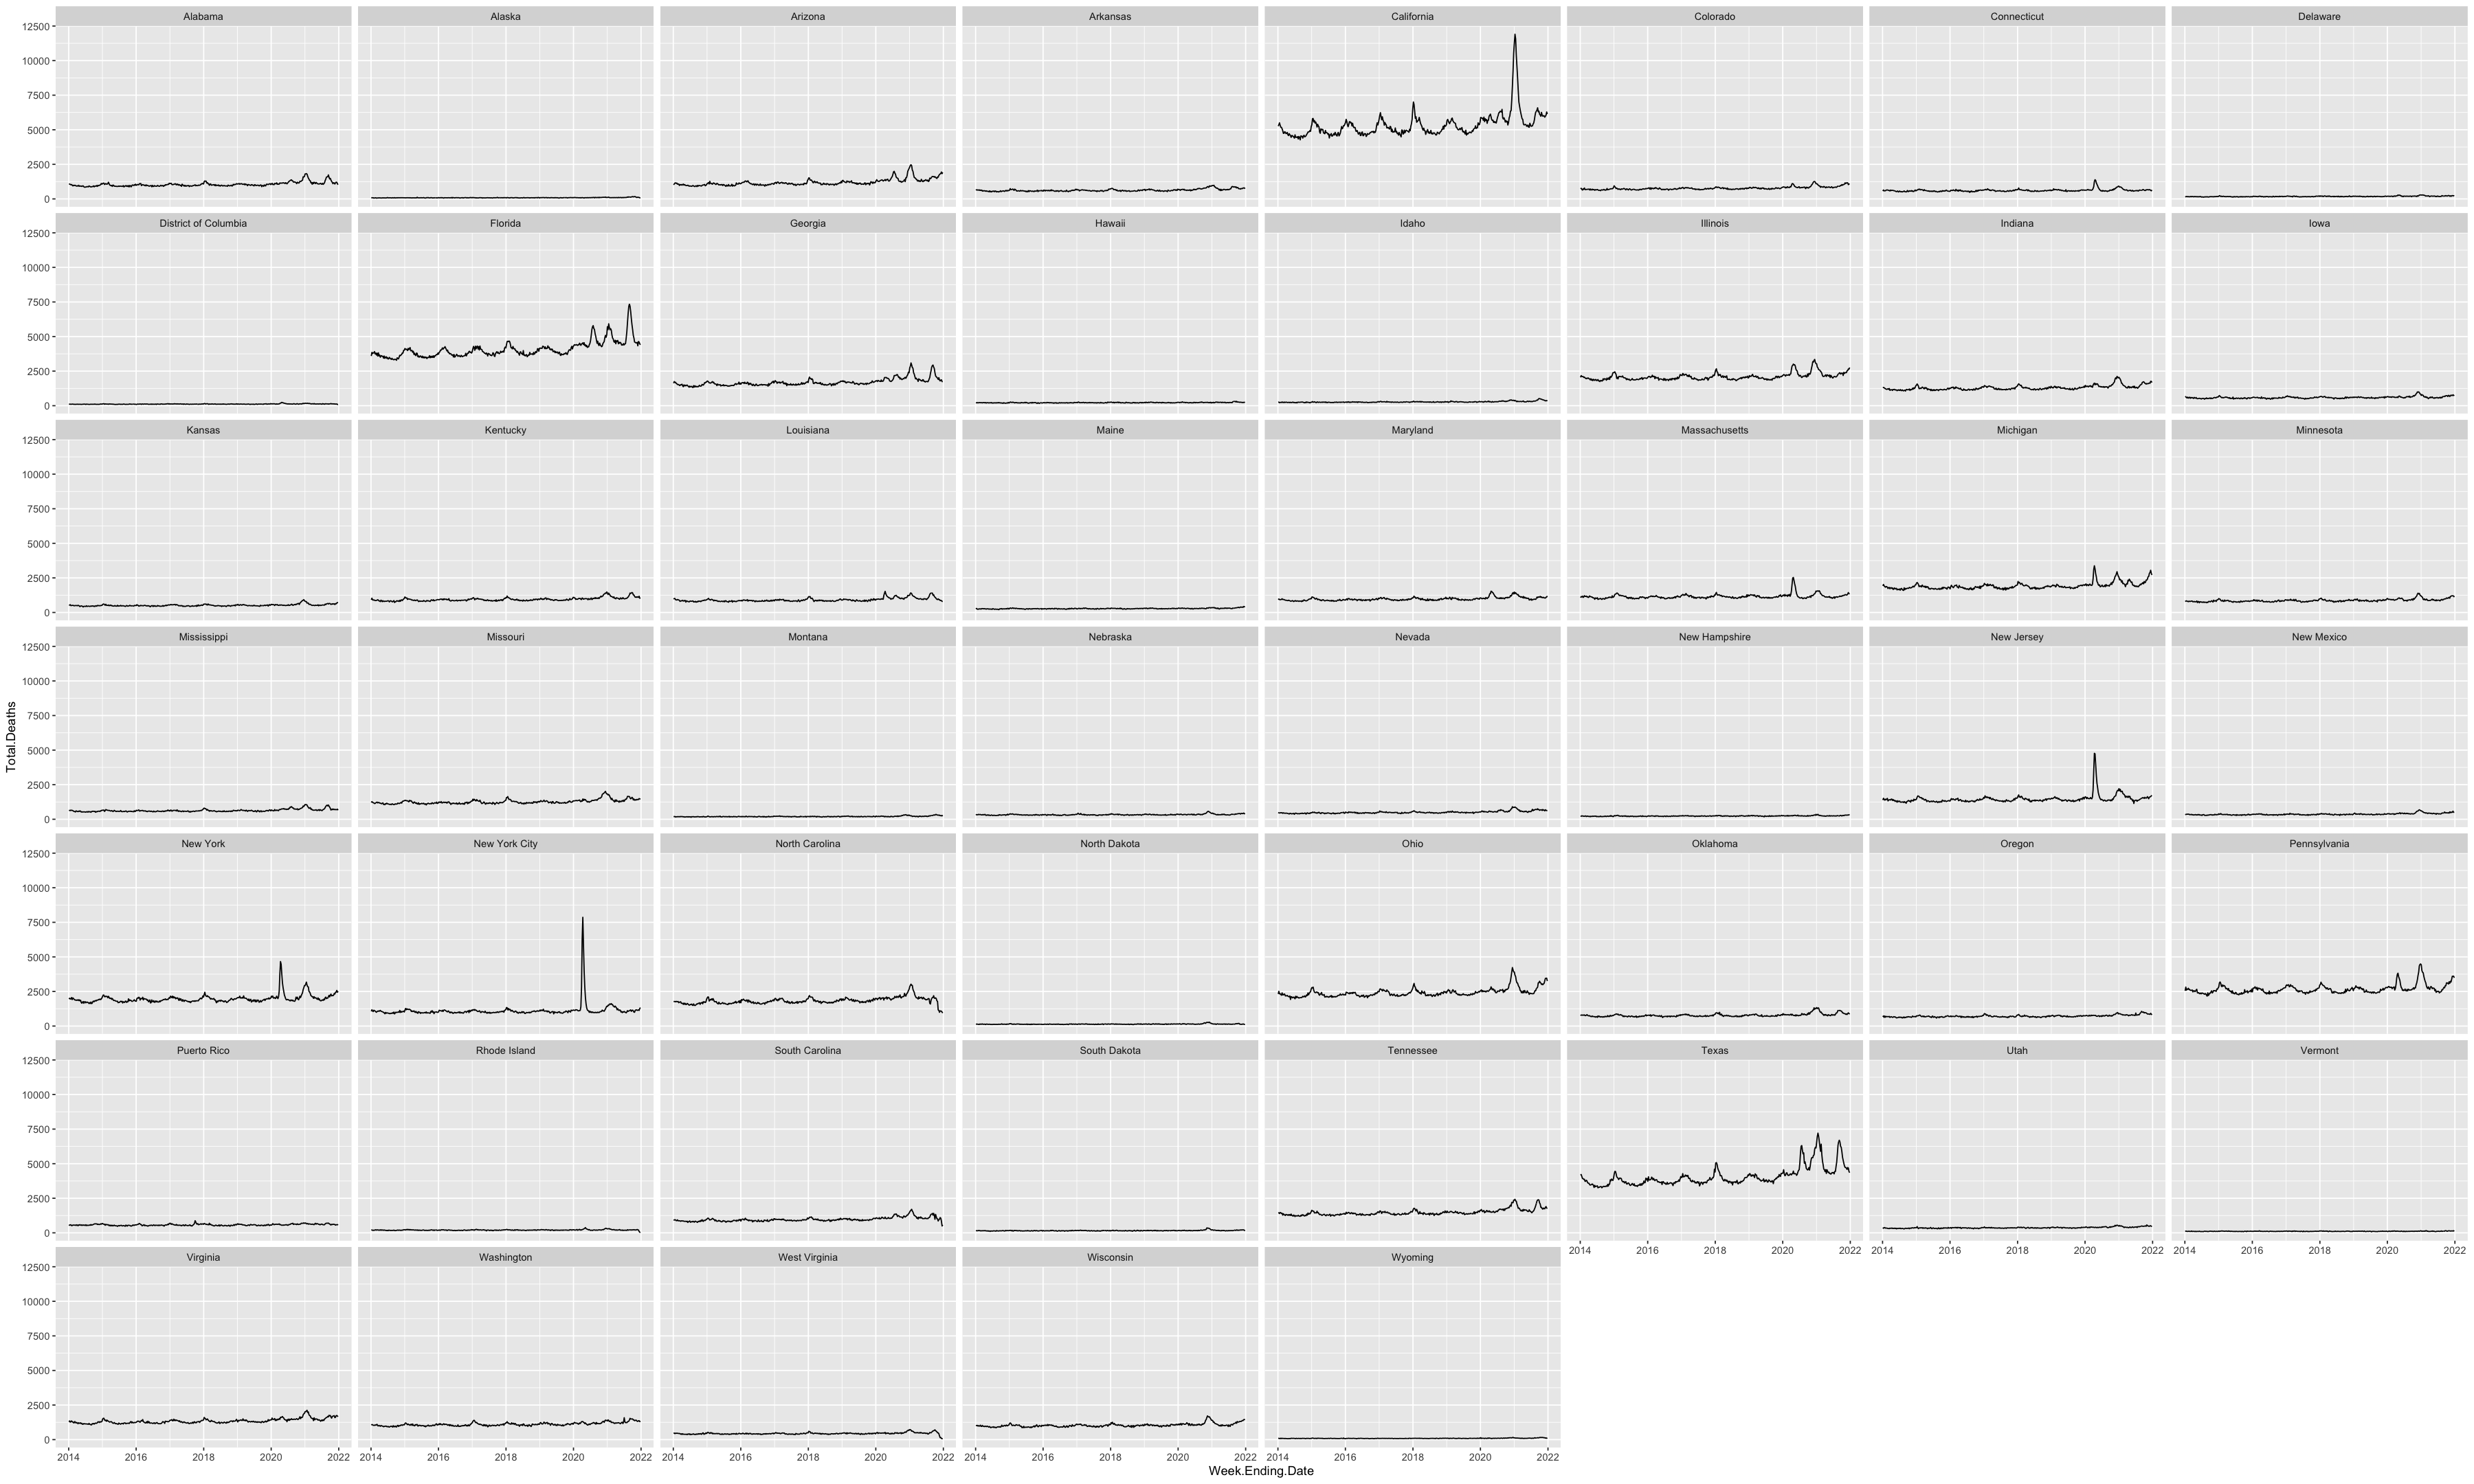

In [88]:
# Plot raw death counts for each state
options(repr.plot.width=30, repr.plot.height=18)
c = ggplot(us_death_all[us_death_all$State != "United States",], aes(Week.Ending.Date, Total.Deaths))
c + facet_wrap(~as.factor(State)) + geom_line()

In [93]:
state_normalized = us_death_all %>% group_by(State) %>% summarise(data_set=data_set, 
                                                                  Week.Ending.Date = Week.Ending.Date, 
                                                                  norm = (Total.Deaths - min(Total.Deaths)) / (max(Total.Deaths) - min(Total.Deaths)))


`summarise()` has grouped output by 'State'. You can override using the `.groups` argument.



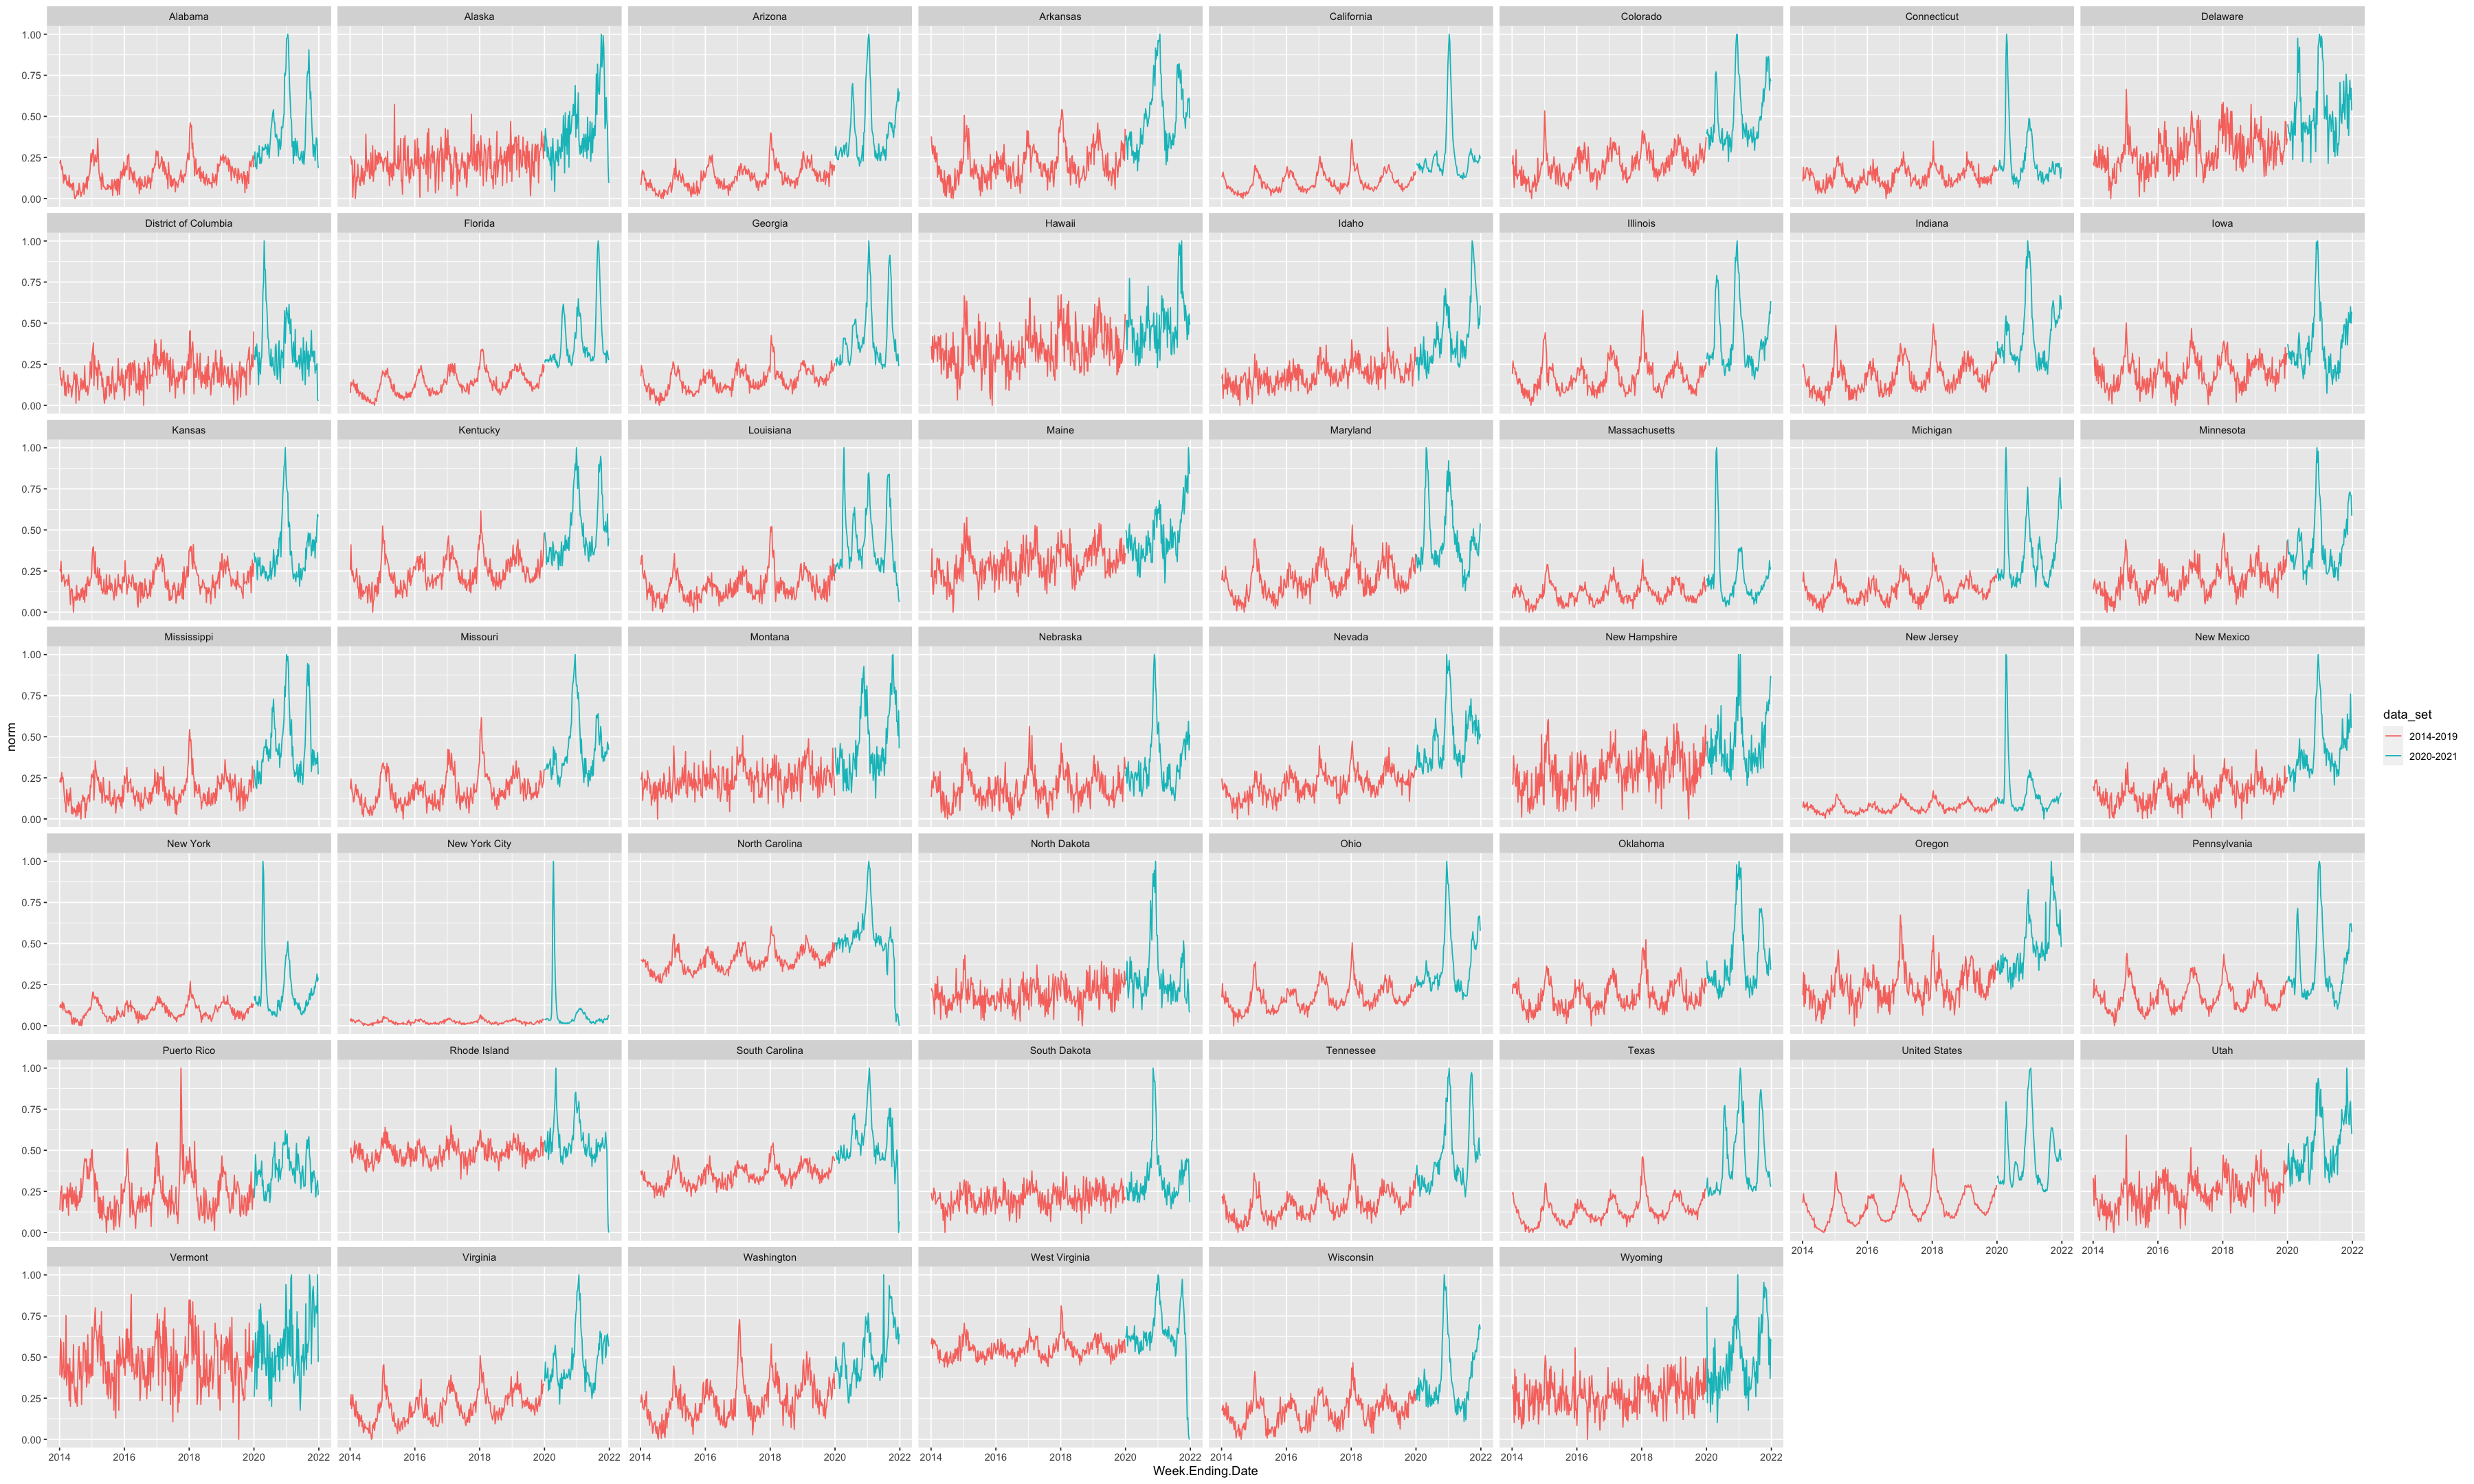

In [94]:
options(repr.plot.width=30, repr.plot.height=18)
c = ggplot(state_normalized, aes(Week.Ending.Date, norm, color=data_set))
c + facet_wrap(~as.factor(State)) + geom_line()

In [153]:
### Find contribution of each state on national counts
recent_agg_deaths_norm = state_normalized[year(state_normalized$Week.Ending.Date)> 2019 & state_normalized$State == "United States", ]
recent_state_deaths_norm = state_normalized[year(state_normalized$Week.Ending.Date)> 2019 & state_normalized$State != "United States", ]
pivot_recent_state_deaths = pivot_wider(recent_state_deaths_norm, values_from="norm", names_from="State")
# Regress national deaths onto statewide deaths (Note we need an intercept due to normalization mean shift)
lmfit = lm(recent_agg_deaths_norm$norm ~ ., pivot_recent_state_deaths[, ! colnames(pivot_recent_state_deaths) %in% c("data_set", "MMWR.Week", "Week.Ending.Date") ])
summary(lmfit)

Warning message in summary.lm(lmfit):
“essentially perfect fit: summary may be unreliable”



Call:
lm(formula = recent_agg_deaths_norm$norm ~ ., data = pivot_recent_state_deaths[, 
    !colnames(pivot_recent_state_deaths) %in% c("data_set", "MMWR.Week", 
        "Week.Ending.Date")])

Residuals:
       Min         1Q     Median         3Q        Max 
-6.503e-17 -1.157e-17  1.378e-18  1.009e-17  5.161e-17 

Coefficients:
                         Estimate Std. Error    t value Pr(>|t|)    
(Intercept)            -8.713e-02  6.934e-17 -1.257e+15   <2e-16 ***
Alabama                 2.417e-02  9.670e-17  2.500e+14   <2e-16 ***
Alaska                  2.828e-03  3.842e-17  7.361e+13   <2e-16 ***
Arizona                 3.886e-02  8.169e-17  4.756e+14   <2e-16 ***
Arkansas                1.190e-02  6.815e-17  1.746e+14   <2e-16 ***
California              1.879e-01  1.128e-16  1.665e+15   <2e-16 ***
Colorado                1.635e-02  7.404e-17  2.209e+14   <2e-16 ***
Connecticut             2.253e-02  1.420e-16  1.586e+14   <2e-16 ***
Delaware                4.033e-03  4.399e-17  9

In [141]:
# Print 10 most important states
df = data.frame(coefs=lmfit$coef / sum(lmfit$coef), state=names(lmfit$coef))
head(df[order(df$coefs, decreasing=TRUE), ], 10)

,coefs,state
,<dbl>,<chr>
California,0.12407822,California
`New York City`,0.11347172,`New York City`
Florida,0.06615664,Florida
Texas,0.06427249,Texas
`New Jersey`,0.05894487,`New Jersey`
`New York`,0.04942663,`New York`
Pennsylvania,0.03781308,Pennsylvania
Ohio,0.03750447,Ohio
`North Carolina`,0.03388234,`North Carolina`


In [152]:
# Verify that there is no systematic bias between data sets
# by looking at the significance of the intercept when regression national deaths on statewide deaths 
# *for the whole period (2014-2021)*
pivot_all = pivot_wider(us_death_all, values_from="Total.Deaths", names_from="State")
lmfit_raw = lm(unlist(pivot_all[, c("United States")]) ~ ., data=pivot_all[, ! colnames(pivot_all) %in% c("United States", "Week.Ending.Date", "MMWR.Week")])
summary(lmfit_raw)

Warning message in summary.lm(lmfit_raw):
“essentially perfect fit: summary may be unreliable”



Call:
lm(formula = unlist(pivot_all[, c("United States")]) ~ ., data = pivot_all[, 
    !colnames(pivot_all) %in% c("United States", "Week.Ending.Date", 
        "MMWR.Week")])

Residuals:
       Min         1Q     Median         3Q        Max 
-1.627e-10 -1.788e-12  2.620e-13  2.409e-12  1.862e-11 

Coefficients:
                         Estimate Std. Error    t value Pr(>|t|)    
(Intercept)            -1.759e-12  9.815e-12 -1.790e-01   0.8579    
data_set2020-2021       1.338e-12  2.419e-12  5.530e-01   0.5804    
Alabama                 1.000e+00  1.395e-14  7.166e+13   <2e-16 ***
Alaska                  1.000e+00  4.500e-14  2.222e+13   <2e-16 ***
Arizona                 1.000e+00  8.015e-15  1.248e+14   <2e-16 ***
Arkansas                1.000e+00  1.644e-14  6.082e+13   <2e-16 ***
California              1.000e+00  2.319e-15  4.312e+14   <2e-16 ***
Colorado                1.000e+00  1.462e-14  6.839e+13   <2e-16 ***
Connecticut             1.000e+00  1.810e-14  5.525e+13   <2e-